In [1]:
import pandas as pd
import numpy as np
import cv2
import pickle

In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [52]:
import matplotlib.pyplot as plt

In [64]:
import seaborn as sns

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve

In [62]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from time import time
import keras
import keras.backend as K
from keras import metrics
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
comandos = pd.concat([pd.DataFrame(load_file('./comando.pkl')),\
          pd.DataFrame(load_file('./comando2.pkl'))],\
          axis=0)

In [5]:
comandos.describe()

,0,1,2,3
count,2612.000000,2612.000000,2612.000000,2612.000000
mean,0.001531,0.018377,0.795559,0.017228
std,0.660186,0.145292,0.403370,0.130146
min,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
comandos['direita'] = comandos[0].map(lambda x: 1 if x == 1 else 0)
comandos['esquerda'] = comandos[0].map(lambda x: 1 if x == -1 else 0)
comandos['baixo'] = comandos[1].map(lambda x: 1 if x == 1 else 0)
comandos['cima'] = comandos[1].map(lambda x: 1 if x == -1 else 0)

In [7]:
comandos = comandos[[2,3,'direita','esquerda','cima','baixo']].rename(index=str, columns={2:'acelera',3:'freia'})

In [8]:
imagens = []
for img in load_file('./img.pkl'):
  imagens.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255)
for img in load_file('./img2.pkl'):
  imagens.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255)

In [0]:
#teste
#gray = cv2.cvtColor(imagens[0], cv2.COLOR_BGR2GRAY)
#cv2.imwrite('/content/drive/My Drive/Colab Notebooks/img.jpg',gray)

In [9]:
imagens =  np.array(imagens).reshape((2612, 220, 320,1))

In [10]:
#input_shape = (img_rows, img_cols, 1)
input_shape = (220, 320,1)
num_classes = comandos.shape[1]
batch_size = 64
epochs = 100

In [94]:
num_classes

6

In [33]:
# CRIANDO MODELO

"""
model = Sequential()
model.add(Conv2D(128, kernel_size=(8, 8),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))
"""
model = Sequential()
model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=input_shape))
model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2056, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 108, 158, 24)      624       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 52, 77, 36)        21636     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 37, 48)        43248     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 22, 35, 64)        27712     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 20, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 16, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 10, 16, 64)        0         
__________

In [35]:
imagens.shape[0]

2612

In [36]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,imagens.shape[0]),range(0,imagens.shape[0]), test_size=0.05, random_state=42)

In [37]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [38]:
imagens[X_train,:,:,:].shape

(2481, 220, 320, 1)

In [39]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20,verbose=0, mode='min')
mcp_save = ModelCheckpoint('./modelo_outrun_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.fit(imagens[X_train,:,:,:], comandos.iloc[X_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(imagens[X_test,:,:,:], comandos.iloc[X_test]),
          callbacks=[earlyStopping,reduce_lr_loss,mcp_save])
score = model.evaluate(imagens[X_test,:,:,:], comandos.iloc[X_test], verbose=0)
print('Test loss:', score[0])

/home/ormenesse/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
W0820 22:38:00.629297 140190042101568 deprecation.py:323] From /home/ormenesse/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2481 samples, validate on 131 samples
Epoch 1/100
2481/2481 [==============================] - 84s 34ms/step - loss: 1.7907 - acc: 0.6622 - val_loss: 1.3149 - val_acc: 0.9237
Epoch 2/100
2481/2481 [==============================] - 84s 34ms/step - loss: 1.5628 - acc: 0.8476 - val_loss: 1.2591 - val_acc: 0.9237
Epoch 3/100
2481/2481 [==============================] - 86s 35ms/step - loss: 1.5145 - acc: 0.8980 - val_loss: 1.2367 - val_acc: 0.9237
Epoch 4/100
2481/2481 [==============================] - 86s 35ms/step - loss: 1.4596 - acc: 0.9081 - val_loss: 1.2092 - val_acc: 0.9237
Epoch 5/100
2481/2481 [==============================] - 86s 35ms/step - loss: 1.4431 - acc: 0.9141 - val_loss: 1.2171 - val_acc: 0.9237
Epoch 6/100
2481/2481 [==============================] - 88s 36ms/step - loss: 1.4179 - acc: 0.9154 - val_loss: 1.2172 - val_acc: 0.9237
Epoch 7/100
2481/2481 [==============================] - 92s 37ms/step - loss: 1.3999 - acc: 0.9158 - val_loss: 1.1952 - val_acc: 0

2481/2481 [==============================] - 89s 36ms/step - loss: 1.2718 - acc: 0.9158 - val_loss: 1.1446 - val_acc: 0.9237
Epoch 60/100
2481/2481 [==============================] - 89s 36ms/step - loss: 1.2668 - acc: 0.9158 - val_loss: 1.1495 - val_acc: 0.9237
Epoch 61/100
2481/2481 [==============================] - 88s 35ms/step - loss: 1.2712 - acc: 0.9158 - val_loss: 1.1339 - val_acc: 0.9237
Epoch 62/100
2481/2481 [==============================] - 89s 36ms/step - loss: 1.2706 - acc: 0.9158 - val_loss: 1.1381 - val_acc: 0.9237
Epoch 63/100
2481/2481 [==============================] - 89s 36ms/step - loss: 1.2694 - acc: 0.9158 - val_loss: 1.1365 - val_acc: 0.9237
Epoch 64/100
2481/2481 [==============================] - 88s 36ms/step - loss: 1.2584 - acc: 0.9158 - val_loss: 1.1593 - val_acc: 0.9237

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 65/100
2481/2481 [==============================] - 89s 36ms/step - loss: 1.2598 - acc: 0.9158 - va

In [40]:
resultados = pd.DataFrame(model.predict_proba(imagens),columns=['acelera','freia','direita','esquerda','cima','baixo']).round(2)

In [41]:
resultados.describe()

,acelera,freia,direita,esquerda,cima,baixo
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,0.992999,0.025142,0.264009,0.241045,0.005815,0.034950
std,0.018784,0.042473,0.093598,0.099873,0.016230,0.049344
min,0.900000,0.000000,0.040000,0.020000,0.000000,0.000000
25%,1.000000,0.000000,0.190000,0.160000,0.000000,0.000000
50%,1.000000,0.010000,0.270000,0.250000,0.000000,0.010000
75%,1.000000,0.030000,0.340000,0.320000,0.000000,0.050000
max,1.000000,0.190000,0.430000,0.420000,0.090000,0.210000


-------------------------------------------------------------------------------------------------------------------

#### Loading my Model

In [95]:
def generate_model():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=input_shape))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(2056, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model

In [96]:
model = generate_model()

In [97]:
model.load_weights('./modelo_outrun_3.hdf5')

In [98]:
type(model)

keras.engine.sequential.Sequential

In [114]:
imagens.shape

(2612, 220, 320, 1)

In [99]:
resultados = pd.DataFrame(model.predict_proba(imagens),columns=['acelera','freia','direita','esquerda','cima','baixo']).round(2)

In [100]:
resultados.describe()

,acelera,freia,direita,esquerda,cima,baixo
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,0.996167,0.018825,0.252447,0.234793,0.003331,0.027056
std,0.012883,0.033411,0.082938,0.085963,0.011344,0.039580
min,0.930000,0.000000,0.050000,0.040000,0.000000,0.000000
25%,1.000000,0.000000,0.190000,0.170000,0.000000,0.000000
50%,1.000000,0.010000,0.260000,0.240000,0.000000,0.010000
75%,1.000000,0.020000,0.320000,0.300000,0.000000,0.040000
max,1.000000,0.160000,0.410000,0.400000,0.060000,0.180000


------------------------------------------------------------------------------------------------------------------------

# Roc of the Models

In [101]:
comandos.columns

Index(['acelera', 'freia', 'direita', 'esquerda', 'cima', 'baixo'], dtype='object')

In [102]:
def curva_roc(df_target,predictions,title=''):
    fpr, tpr, threshold = roc_curve(df_target, predictions)
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(df_target, predictions))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic REAIS'+title)
    plt.legend(loc="lower right")
    plt.show()

In [103]:
def limiar_escore(df_target,predictions):
    #Imprimindo limiar de Escore
    fpr, tpr, threshold = roc_curve(df_target, predictions)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    print('Limiar que maxima especificidade e sensitividade:')
    print(list(roc_t['threshold']))
    #analisando modelo com novo limiar
    tn, fp, fn, tp = confusion_matrix(df_target, [1 if item>=list(roc_t['threshold'])[0] else 0 for item in predictions]).ravel()
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    acuracia = (tp+tn)/(tn+fp+fn+tp)
    F = (2*Precision*Recall)/(Precision+Recall)
    print('Precision',Precision)
    print('Recall',Recall)
    print('Acuracia',acuracia)
    print('F-Score',F)

Acelera

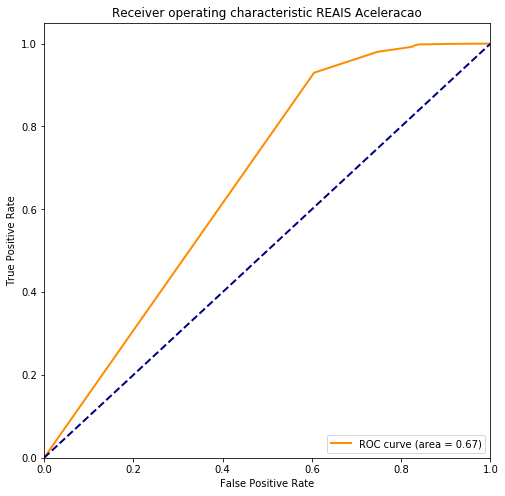

Limiar que maxima especificidade e sensitividade:
[1.0]
Precision 0.8567627494456763
Recall 0.9297401347449471
Acuracia 0.8204441041347627
F-Score 0.8917609046849758


In [104]:
curva_roc(comandos['acelera'],resultados['acelera'],' Aceleracao')
limiar_escore(comandos['acelera'],resultados['acelera'])

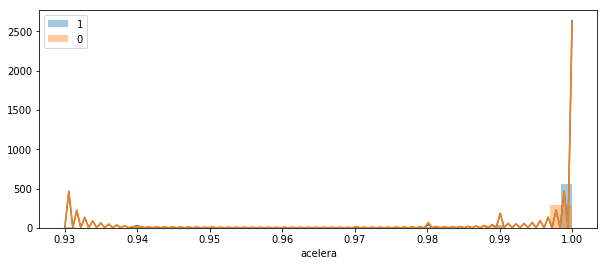

In [105]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['acelera'].iloc[comandos[comandos['acelera'] == 1].index])
sns.distplot(resultados['acelera'].iloc[comandos[comandos['acelera'] == 0].index])
plt.legend([1,0])
plt.show()

Freio

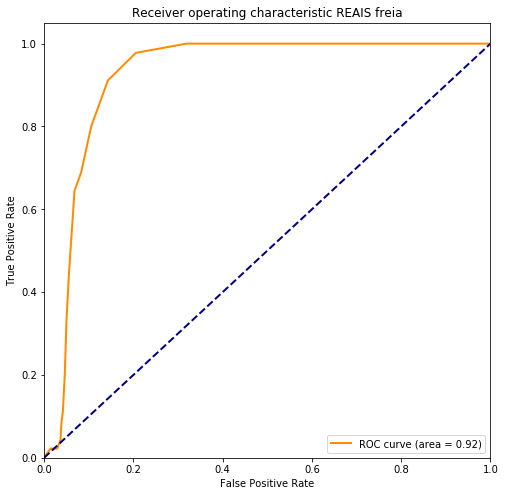

Limiar que maxima especificidade e sensitividade:
[0.03999999910593033]
Precision 0.10049019607843138
Recall 0.9111111111111111
Acuracia 0.8579632465543645
F-Score 0.18101545253863136


In [106]:
curva_roc(comandos['freia'],resultados['freia'],' freia')

limiar_escore(comandos['freia'],resultados['freia'])

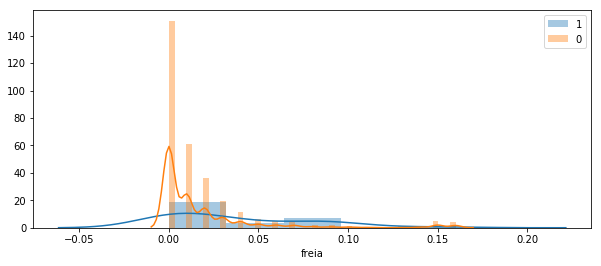

In [107]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['freia'].iloc[comandos[comandos['freia'] == 1].index])
sns.distplot(resultados['freia'].iloc[comandos[comandos['freia'] == 0].index])
plt.legend([1,0])
plt.show()

direita

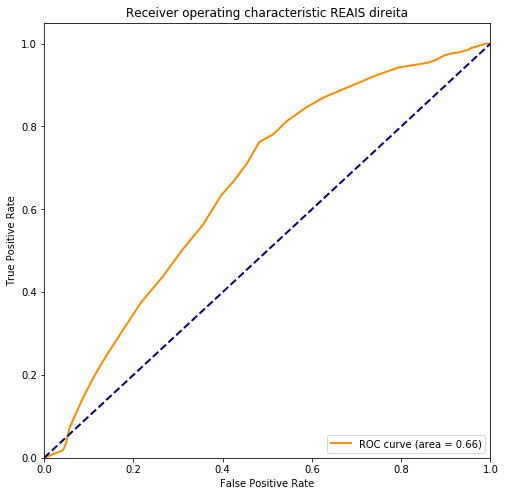

Limiar que maxima especificidade e sensitividade:
[0.2800000011920929]
Precision 0.30887372013651876
Recall 0.6339754816112084
Acuracia 0.6098774885145483
F-Score 0.41537578886976473


In [108]:
curva_roc(comandos['direita'],resultados['direita'],' direita')

limiar_escore(comandos['direita'],resultados['direita'])

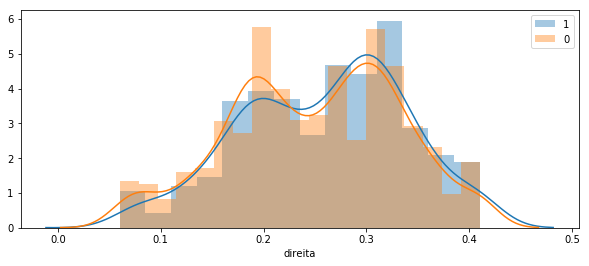

In [109]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['direita'].iloc[comandos[comandos['direita'] == 1].index])
sns.distplot(resultados['direita'].iloc[comandos[comandos['direita'] == 0].index])
plt.legend([1,0])
plt.show()

Esquerda

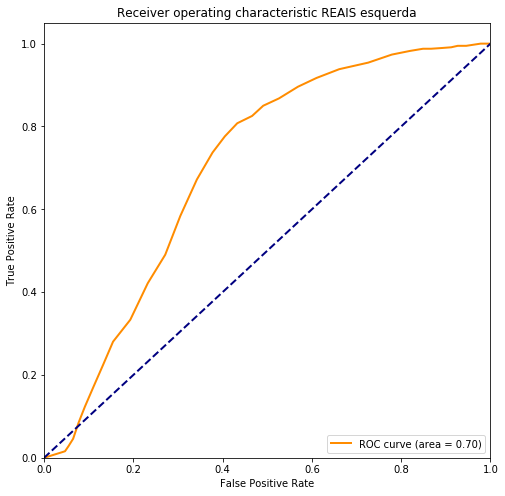

Limiar que maxima especificidade e sensitividade:
[0.27000001072883606]
Precision 0.3524514338575393
Recall 0.671957671957672
Acuracia 0.6607963246554365
F-Score 0.46237864077669905


In [110]:
curva_roc(comandos['esquerda'],resultados['esquerda'],' esquerda')

limiar_escore(comandos['esquerda'],resultados['esquerda'])

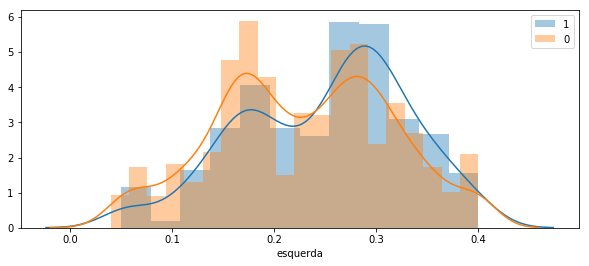

In [111]:
plt.figure(figsize=(10,4))
sns.distplot(resultados['esquerda'].iloc[comandos[comandos['esquerda'] == 1].index])
sns.distplot(resultados['esquerda'].iloc[comandos[comandos['esquerda'] == 0].index])
plt.legend([1,0])
plt.show()

Cima

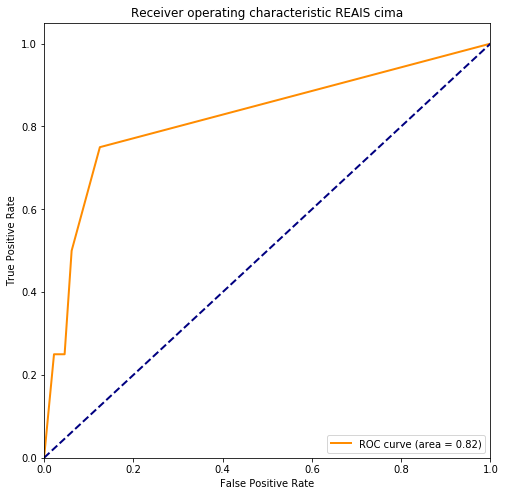

Limiar que maxima especificidade e sensitividade:
[0.009999999776482582]
Precision 0.00911854103343465
Recall 0.75
Acuracia 0.8748085758039816
F-Score 0.018018018018018014


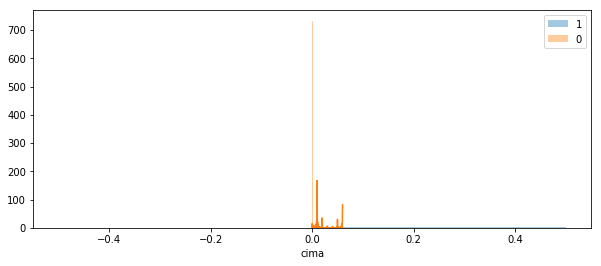

In [112]:
curva_roc(comandos['cima'],resultados['cima'],' cima')

limiar_escore(comandos['cima'],resultados['cima'])

plt.figure(figsize=(10,4))
sns.distplot(resultados['cima'].iloc[comandos[comandos['cima'] == 1].index])
sns.distplot(resultados['cima'].iloc[comandos[comandos['cima'] == 0].index])
plt.legend([1,0])
plt.show()

Baixo

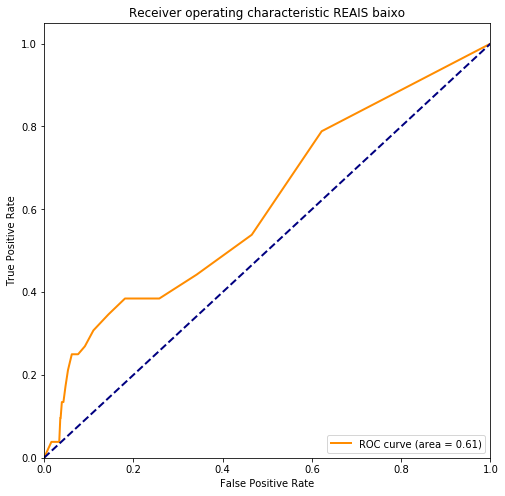

Limiar que maxima especificidade e sensitividade:
[0.019999999552965164]
Precision 0.022969647251845776
Recall 0.5384615384615384
Acuracia 0.5348392036753445
F-Score 0.044059795436664044


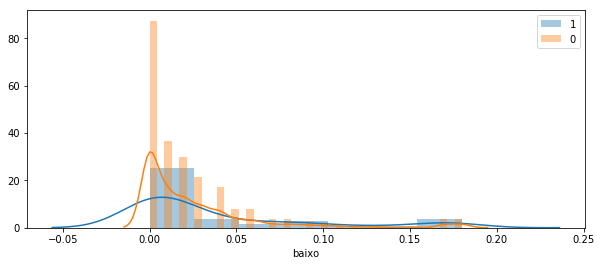

In [113]:
curva_roc(comandos['baixo'],resultados['baixo'],' baixo')

limiar_escore(comandos['baixo'],resultados['baixo'])

plt.figure(figsize=(10,4))
sns.distplot(resultados['baixo'].iloc[comandos[comandos['baixo'] == 1].index])
sns.distplot(resultados['baixo'].iloc[comandos[comandos['baixo'] == 0].index])
plt.legend([1,0])
plt.show()